# Context-sensitive Spelling Correction

The goal of the assignment is to implement context-sensitive spelling correction. The input of the code will be a set of text lines and the output will be the same lines with spelling mistakes fixed.

Submit the solution of the assignment to Moodle as a link to your GitHub repository containing this notebook.

Useful links:
- [Norvig's solution](https://norvig.com/spell-correct.html)
- [Norvig's dataset](https://norvig.com/big.txt)
- [Ngrams data](https://www.ngrams.info/download_coca.asp)

Grading:
- 60 points - Implement spelling correction
- 20 points - Justify your decisions
- 20 points - Evaluate on a test set


## Implement context-sensitive spelling correction

Your task is to implement context-sensitive spelling corrector using N-gram language model. The idea is to compute conditional probabilities of possible correction options. For example, the phrase "dking sport" should be fixed as "doing sport" not "dying sport", while "dking species" -- as "dying species".

The best way to start is to analyze [Norvig's solution](https://norvig.com/spell-correct.html) and [N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

You may also want to implement:
- spell-checking for a concrete language - Russian, Tatar, etc. - any one you know, such that the solution accounts for language specifics,
- some recent (or not very recent) paper on this topic,
- solution which takes into account keyboard layout and associated misspellings,
- efficiency improvement to make the solution faster,
- any other idea of yours to improve the Norvig’s solution.

IMPORTANT:  
Your project should not be a mere code copy-paste from somewhere. You must provide:
- Your implementation
- Analysis of why the implemented approach is suggested
- Improvements of the original approach that you have chosen to implement

In [25]:
!gdown 1diUts9JmGzoY2GUH-FrEKh6ILI8Cb2Wx

Downloading...
From: https://drive.google.com/uc?id=1diUts9JmGzoY2GUH-FrEKh6ILI8Cb2Wx
To: /content/bigrams.txt
100% 17.7M/17.7M [00:00<00:00, 150MB/s]


In [26]:
with open('bigrams.txt', 'r', encoding='ISO-8859-1') as file:
    data = file.read()

n_grams = {}
backward_n_grams = {}


#Transforming to ascii because otherwise there are errors with the Levenstein distance
ascii_content = data.encode('ascii', errors='ignore').decode('ascii')

#Creating n_grams and backward_n_grams dicts
for line in ascii_content.strip().split('\n'):
    parts = line.split('\t')
    count, word1, word2 = int(parts[0]), parts[1], parts[2]

    if word1 not in n_grams:
        n_grams[word1] = {}

    n_grams[word1][word2] = count



    if word2 not in backward_n_grams:
        backward_n_grams[word2] = {}

    backward_n_grams[word2][word1] = count

n_grams

{'a': {'a': 275,
  'aaa': 31,
  'all': 29,
  'an': 45,
  'and': 192,
  'another': 39,
  'at': 25,
  'b': 82,
  'b+': 45,
  'b-17': 26,
  'b-2': 31,
  'b-52': 54,
  'b-movie': 39,
  'b-plus': 40,
  'b.a': 168,
  'b.f.a': 64,
  'b.s': 84,
  'ba': 66,
  'babble': 41,
  'babbling': 28,
  'babe': 159,
  'baboon': 83,
  'baby': 9744,
  'baby-faced': 31,
  'baby-sitter': 122,
  'babysitter': 237,
  'babysitting': 23,
  'baccalaureate': 95,
  'bach': 71,
  'bachelor': 1342,
  'bachelorette': 27,
  'bachelors': 53,
  'back': 1924,
  'back-and-forth': 38,
  'back-door': 24,
  'back-to-basics': 29,
  'back-to-school': 27,
  'back-up': 100,
  'backboard': 53,
  'backbone': 72,
  'backcountry': 93,
  'backdoor': 60,
  'backdrop': 728,
  'backer': 47,
  'backfire': 23,
  'background': 1262,
  'backhand': 59,
  'backhanded': 46,
  'backhoe': 113,
  'backing': 43,
  'backlash': 721,
  'backlit': 38,
  'backlog': 183,
  'backpack': 481,
  'backpacker': 59,
  'backpacking': 31,
  'backseat': 182,
  'bac

In [27]:
#Defining adjacent keys

keyboard_layout = {
    'q': ['w', 'a', 's'],
    'w': ['q', 'e', 's', 'a', 'd'],
    'e': ['w', 'r', 'd', 's', 'f'],
    'r': ['e', 't', 'f', 'd', 'g'],
    't': ['r', 'y', 'g', 'f', 'h'],
    'y': ['t', 'u', 'h', 'g', 'j'],
    'u': ['y', 'i', 'j', 'h', 'k'],
    'i': ['u', 'o', 'k', 'j', 'l'],
    'o': ['i', 'p', 'l', 'k'],
    'p': ['o', 'l'],

    'a': ['q', 'w', 's', 'z'],
    's': ['q', 'w', 'e', 'a', 'd', 'z', 'x'],
    'd': ['w', 'e', 'r', 's', 'f', 'x', 'c'],
    'f': ['e', 'r', 't', 'd', 'g', 'c', 'v'],
    'g': ['r', 't', 'y', 'f', 'h', 'v', 'b'],
    'h': ['t', 'y', 'u', 'g', 'j', 'b', 'n'],
    'j': ['y', 'u', 'i', 'h', 'k', 'n', 'm'],
    'k': ['u', 'i', 'o', 'j', 'l', 'm'],
    'l': ['i', 'o', 'p', 'k'],

    'z': ['a', 's', 'x'],
    'x': ['s', 'd', 'z', 'c'],
    'c': ['d', 'f', 'x', 'v'],
    'v': ['f', 'g', 'c', 'b'],
    'b': ['g', 'h', 'v', 'n'],
    'n': ['h', 'j', 'b', 'm'],
    'm': ['j', 'k', 'n']
}

In [28]:
!pip install weighted-levenshtein

In [29]:
import numpy as np
from weighted_levenshtein import lev, osa, dam_lev

substitute_costs = np.ones((128, 128), dtype=np.float64)

#Setting weight of the substitution to the adjacent key on a keyboard to 0.75
for key1 in keyboard_layout:
  for key2 in keyboard_layout[key1]:
    substitute_costs[ord(key2), ord(key1)] = 0.75


print(lev('BANANAS', 'BANANA', substitute_costs=substitute_costs))
print(lev('BANANQ', 'BANANA', substitute_costs=substitute_costs))

print(lev('bananq', 'banana', substitute_costs=substitute_costs))

1.0
1.0
0.75


In [30]:
!gdown 1n6EIx7B79E2FAFMBmPf2-MT7VF4Jhh9S
!gdown 1NdNrRpRatHHO_-b8vmYO67byxr5Jk0gd
!gdown 1F4HbzbSN3mF-bq9N-rsCAWM_ro7HhlAJ
!gdown 1w3xgH8IvlIapHiDOeiobt1UMxftyebB-

Downloading...
From: https://drive.google.com/uc?id=1n6EIx7B79E2FAFMBmPf2-MT7VF4Jhh9S
To: /content/test.1blm
100% 32.8M/32.8M [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NdNrRpRatHHO_-b8vmYO67byxr5Jk0gd
To: /content/test.1blm.noise.word
100% 33.0M/33.0M [00:00<00:00, 151MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F4HbzbSN3mF-bq9N-rsCAWM_ro7HhlAJ
To: /content/test.1blm.noise.random
100% 33.3M/33.3M [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1w3xgH8IvlIapHiDOeiobt1UMxftyebB-
To: /content/big.txt
100% 6.49M/6.49M [00:00<00:00, 160MB/s]


In [31]:
#Norvig's solution

import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())):
    "Probability of `word`."
    return WORDS[word] / N

def correction(word):
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))


correction('korrectud')

'corrected'

In [32]:
import string

def is_punctuation(s):
    return all(char in string.punctuation for char in s)

In [33]:
edit_dist_importance = 30
threshold_to_use_original_word = 1



def correct_sent(sentence, verbose=False):
  words = sentence.split()

  #For the first word we use only the backward_n_grams (that is context now is the word after the current word)
  #For the last we use only the usual n_grams
  #For all the others we use both n_gram and backward_n_grams


  for i in range(len(words)):
    if is_punctuation(words[i]):
      continue

    best_candidate = (words[i], threshold_to_use_original_word, 0, threshold_to_use_original_word)


    if i != len(words) - 1:
      #Using backward_n_grams

      current_word = words[i].lower() #We are checking this word for misspelling
      context_word = words[i + 1].lower()

      if context_word in backward_n_grams:
        candidates = backward_n_grams[context_word]

        if verbose:
          print(f"Using backward_n_grams with current_word '{current_word}' and context_word '{context_word}'")

        edit_dists = [lev(s, current_word, substitute_costs=substitute_costs) for s in candidates]

        scores = [num1 / (edit_dist_importance ** num2) for num1, num2 in zip(candidates.values(), edit_dists)]

        sorted_candidates = sorted(zip(candidates, candidates.values(), edit_dists, scores), key=lambda x: x[3], reverse=True)

        largest_candidates = sorted_candidates[:3]
        if verbose:
          print(largest_candidates)

        if best_candidate[3] < largest_candidates[0][3]:
          best_candidate = largest_candidates[0]


    if i != 0:
      #Using usual n_grams

      current_word = words[i].lower() #We are checking this word for misspelling
      context_word = words[i - 1].lower()

      if context_word in n_grams:
        candidates = n_grams[context_word]

        if verbose:
          print(f"Using usual n_grams with current_word '{current_word}' and context_word '{context_word}'")

        edit_dists = [lev(s, current_word, substitute_costs=substitute_costs) for s in candidates]

        scores = [num1 / (edit_dist_importance ** num2) for num1, num2 in zip(candidates.values(), edit_dists)]

        sorted_candidates = sorted(zip(candidates, candidates.values(), edit_dists, scores), key=lambda x: x[3], reverse=True)

        largest_candidates = sorted_candidates[:3]
        if verbose:
          print(largest_candidates)

        if best_candidate[3] < largest_candidates[0][3]:
          best_candidate = largest_candidates[0]



    if best_candidate == (words[i], threshold_to_use_original_word, 0, threshold_to_use_original_word):
      best_candidate = (correction(words[i]), threshold_to_use_original_word, 0, threshold_to_use_original_word)
      if verbose:
        print("USING THE ORIGINAL WORD", words[i], "CORRECTED TO", best_candidate[0])

    if words[i][0].isupper():
      words[i] = best_candidate[0][0].upper() + best_candidate[0][1:]
    else:
      words[i] = best_candidate[0]


  return " ".join(words)




#correct_sent("They are human beings and they need to keep a little bit of privacy and freedom in their lives to continue like normal people , to feel that they are unknown and anonymous and they do not have to wear sunglasses , hats or caps every time they want to leave home in order not to be recognised .")
#correct_sent("They spent money")
#ans = correct_sent("Butt since the messive profots turnek into rnormius write downs , their reputauion has fallen even further in the eyes of the general public .")
#ans = correct_sent("But I rialixed that jinding something to do that you love from Monda to Friday was a vital ingredient to a fulfilling lifi .")
ans = correct_sent("He would rathlr quietly prepare foe the next game two shrd his sport coat , roll up his skeves and do his aob as if he was just anothsr orking man .")

print(ans)

He would rather quietly prepare for the next game two and his sport coat , roll up his sleeves and do his job as if he was just another working man .


## Justify your decisions

Write down justificaitons for your implementation choices. For example, these choices could be:
- Which ngram dataset to use
- Which weights to assign for edit1, edit2 or absent words probabilities
- Beam search parameters
- etc.

##Justification
1. **The solution uses bigrams.**
It was decided to use bigram dataset because the fivegram dataset provided doesn't look like it is complete.
For example, Google's fivegrams as 4 times as big as bigrams: https://blog.research.google/2006/08/all-our-n-gram-are-belong-to-you.html
And the provided fivegrams are not even twice as big as the bigrams, which means bigrams should be more complete.


2. **The solution uses Levenshtein distance.** It was done so to avoid generating possible combinations.

- This way we can easily combine the word probability from bigrams and the edit distance, so that if the word has more typos but it is very probably we still can consider it (which is number 2 in the future work in Norvig's solution).
- Also, this way we cover cases with edit distance of 3, even though they are very rare (which is number 3 in the future work in Norvig's solution).
- In particular the Levenshtein distance used in the solution is **weighed Damerau–Levenshtein distance.** This is an extention of Levenshtein distance that has transposition of two adjacent letter in addition to insertions, deletions and substitutions. This might be helpful as it is common while typing on a keyboard to press one key slightly faster than another key, resulting in a transposition.

3. **The solution takes into account the keyboard layout.** Weight of the substitution to the adjacent key on a keyboard is set to 0.75 instead of default 1.

4. **The solution uses both preceding and succeeding words as context.**

5. **The solution still uses Norvig's solution if bigrams didn't help.** It the process of testing the implementation it turned out that sometimes bigrams cannot be used for example when two starting words are corrupted and are not found in the bigrams. So it was decided to add unigrams (that are used in Norvig's solution) to the original implementation to cover these cases.

## Evaluate on a test set

Your task is to generate a test set and evaluate your work. You may vary the noise probability to generate different datasets with varying compexity. Compare your solution to the Norvig's corrector, and report the accuracies.

In [34]:
true_lines = []
with open("test.1blm", 'r') as file:
  for line in file:
    true_lines.append(line.strip().split())


def evaluate(path):
  correct_word_count = 0
  all_word_count = 0

  with open(path, 'r') as file:
    for index, line in enumerate(file):

      if index == 20:
        break

      pred_line = correct_sent(line.strip()).split()

      for i in range(len(pred_line)):
        if pred_line[i] == true_lines[index][i]:
          correct_word_count += 1

      all_word_count += len(pred_line)

  return correct_word_count / all_word_count



def evaluate_norvig(path):
  correct_word_count = 0
  all_word_count = 0

  with open(path, 'r') as file:
    for index, line in enumerate(file):

      if index == 20:
        break

      pred_line = line.strip().split()

      for i in range(len(pred_line)):
        if correction(pred_line[i]) == true_lines[index][i]:
          correct_word_count += 1

      all_word_count += len(pred_line)

  return correct_word_count / all_word_count


accuracy_on_correct_text = evaluate("test.1blm")
print(f"Accuracy on correct text: {accuracy_on_correct_text}")
accuracy_on_noised_text = evaluate("test.1blm.noise.word")
print(f"Accuracy on noised text: {accuracy_on_noised_text}")
accuracy_on_very_noised_text = evaluate("test.1blm.noise.random")
print(f"Accuracy on very noised text: {accuracy_on_very_noised_text}")

norvig_accuracy_on_correct_text = evaluate_norvig("test.1blm")
print(f"Norvig accuracy on correct text: {norvig_accuracy_on_correct_text}")
norvig_accuracy_on_noised_text = evaluate_norvig("test.1blm.noise.word")
print(f"Norvig accuracy on noised text: {norvig_accuracy_on_noised_text}")
norvig_accuracy_on_very_noised_text = evaluate_norvig("test.1blm.noise.random")
print(f"Norvig accuracy on very noised text: {norvig_accuracy_on_very_noised_text}")

Accuracy on correct text: 0.9131313131313131
Accuracy on noised text: 0.8565656565656565
Accuracy on very noised text: 0.8262626262626263
Norvig accuracy on correct text: 0.7232323232323232
Norvig accuracy on noised text: 0.6363636363636364
Norvig accuracy on very noised text: 0.6565656565656566


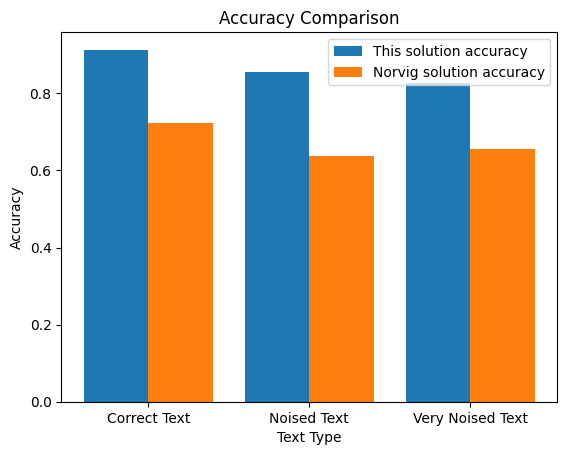

In [43]:
import matplotlib.pyplot as plt

labels = ['Correct Text', 'Noised Text', 'Very Noised Text']
accuracy_values = [accuracy_on_correct_text, accuracy_on_noised_text, accuracy_on_very_noised_text]
norvig_accuracy_values = [norvig_accuracy_on_correct_text, norvig_accuracy_on_noised_text, norvig_accuracy_on_very_noised_text]

x = range(len(labels))

plt.bar(x, accuracy_values, width=0.4, label='This solution accuracy')
plt.bar([p + 0.4 for p in x], norvig_accuracy_values, width=0.4, label='Norvig solution accuracy')

plt.xlabel('Text Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()

plt.show()